In [3]:
import qutip as qt
import qutip.piqs as pq
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
from qutip.measurement import measure

np.set_printoptions(threshold=np.inf)
qt.qutip.about()

#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':16}) # The default font in LaTex
# font.family        : serif
# font.serif         : Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman
# font.sans-serif    : Helvetica, Avant Garde, Computer Modern Sans serif
# font.cursive       : Zapf Chancery
# font.monospace     : Courier, Computer Modern Typewriter
# text.usetex        : true
plt.rc('text', usetex=True)


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.0.3.post1
Numpy Version:      2.0.1
Scipy Version:      1.14.0
Cython Version:     3.0.11
Matplotlib Version: 3.9.1.post1
Python Version:     3.12.4
Number of CPUs:     8
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Darwin (x86_64)
Installation path:  /opt/anaconda3/envs/qutip/lib/python3.12/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can 

In [4]:
# Coefficients of collapse operators in PI Basis
def bm(j,m):
    return (-np.sqrt((j+m)*(j+m-1)))

def dm(j,m):
    return (np.sqrt((j-m+1)*(j-m+2)))

def bp(j,m):
    return (np.sqrt((j-m)*(j-m-1)))

def dp(j,m):
    return (-np.sqrt((j+m+1)*(j+m+2)))

def bz(j,m):
    return (np.sqrt((j-m)*(j+m)))

def dz(j,m):
    return (np.sqrt((j+m+1)*(j-m+1)))

def cj(N,J):
    if J== N/2:
        return (1/(2*J))

    else:
        return ((1/(2*(J)))*((N/2+1)/(J+1)))

def cjp1(N,J):
    return ((1/(2*(J+1)))*((N/2-J)/(2*J+1)))

def cjm1(N,J):
    return ((1/(2*(J)))*((N/2+J+1)/(2*J+1)))

def rate(ch,p,q,N,J,M,dr=1,dt=1):
    r = 0;
    if p==-1:
        if q==-1:
            r = bm(J,M)
        elif q==0:
            r = bz(J,M)
        else:
            r = bp(J,M)
    elif p==0:
        if q==-1:
            r = pq.am(J,M)
            #if ch=='l':
                #r *= cjm1(N,J)
        elif q==0:
            r = M
            #if ch=='l':
                #r *= cjm1(N,J)
        else:
            r = pq.ap(J,M)
            #if ch=='l':
                #r *= cjm1(N,J)
    elif p==1:
        if q==-1:
            r = dm(J,M)
        elif q==0:
            r = dz(J,M)
        else:
            r = dp(J,M)

    else:
        # Continuous dephasing
        r = 1-1j*dt*(-1j*dr[0]*(N/2+M)/2 - 1j*dr[2]*(N/2-M)/2 - 1j*dr[1]*(N/4)/2)
        
    return r

def EncodedSt(M1, M2, α, β, ch, N, J):
    if J<=abs(M1):
        J = abs(M1)
        
    j  = np.array([jj for jj in np.linspace(N/2,N%2/2,int(N//2+1))])
    mj = np.array([int(2*jj+1) for jj in j])
    dim = np.sum(mj)
    st_ind = np.sum(mj[:np.where(j==J)[0][0]])

    Log0 = np.zeros((dim,1),dtype=np.complex128)
    Log1 = np.zeros((dim,1),dtype=np.complex128)

    if ch:
        cm1 = np.sqrt(M2/(M1+M2))
        cm2 = np.sqrt(M1/(M1+M2))
    
        #Logical 0 state
        Log0[st_ind+J-M1] = α*cm1
        Log0[st_ind+J+M2] = α*cm2
    
        #Logical 1 state
        Log1[st_ind+J+M1] = β*cm1
        Log1[st_ind+J-M2] = β*cm2

    else:
        #Logical 0 state
        Log0[st_ind+J-J] = 1
    
        #Logical 1 state
        Log0[st_ind+J-(-J+1)] = 1
        
    Log0 = qt.Qobj(Log0)
    Log1 = qt.Qobj(Log1)
    
    #Encoded state
    EncSt = Log0 + Log1

    return EncSt

def dec_St(St,merr,N,J):
    j  = np.array([jj for jj in np.linspace(N/2,N%2/2,int(N//2+1))])
    mj = np.array([int(2*jj+1) for jj in j])
    dim = np.sum(mj)
    st_ind = np.sum(mj[:np.where(j==J)[0][0]])

    # Finding M levels occupied in the input state in J subspace
    i, _ = np.nonzero(St.data_as("ndarray"))
    mi = [st_ind+J-i[ind] for ind in range(len(i))]

    # Coefficients in individual decay
    
    Md1 = [rate('l',-1,merr,N,J,mi[ind]) for ind in range(len(mi))]
    Md2 = [rate('l',0,merr,N,J,mi[ind]) for ind in range(len(mi))]
    Md3 = [rate('l',1,merr,N,J,mi[ind]) for ind in range(len(mi))]
    
    # Finding possible J subspaces after decay and their coefficients
    if J==N/2:
        Jdec = [J-1,J]
        Cdec = [cjm1(N,J),cj(N,J)]
        Mdec = [Md1,Md2]

    elif J>0 and J<N/2:
        Jdec = [J-1,J,J+1]
        Cdec = [cjm1(N,J),cj(N,J),cjp1(N,J)]
        Mdec = [Md1,Md2,Md3]

    elif J==0:
        Jdec = [J+1]
        Cdec = [cjp1(N,J)]
        Mdec = [Md3]

    else:
        raise ValueError('Invalid J!')
        
    # Computation of States after decay
    St_dec = []
    St_Norm = []
    
    ii = 0
    for J_dec in Jdec:
        st_ind = np.sum(mj[:np.where(j==J_dec)[0][0]])
        st_ind0 = np.sum(mj[:np.where(j==J)[0][0]])
        st_dec = np.zeros((dim,1),dtype=np.complex128)
        for ind in range(len(mi)):
            if mi[ind]+merr <=J_dec and mi[ind]+merr >= -J_dec:
                st_dec[st_ind+J_dec-(mi[ind]+merr)] = Mdec[ii][ind]*St[st_ind0+J-(mi[ind])]
        
        nrm = np.linalg.norm(st_dec)
        St_dec.append(qt.Qobj(st_dec)/nrm)
        St_Norm.append(Cdec[ii]*nrm**2)
        ii += 1
        
    return (St_dec,np.array(St_Norm),Jdec)

def tau(N,J,M1,M2,j,m,ch,dr,dt):
    cm1 = abs(M2)/(abs(M1)+abs(M2))
    cm2 = abs(M1)/(abs(M1)+abs(M2))

    Xm2 = rate(ch,j,m,N,J,M2,dr,dt)
    Xp1 = rate(ch,j,m,N,J,M1,dr,dt)
    
    num = (cm2*Xm2 + cm1*Xp1)
    den = np.sqrt(cm2*(Xm2)**2 + cm1*(Xp1)**2)

    # num = (cm1**2 * Xp1**2 - cm2**2 * Xm2**2)
    # den = (cm1 * Xp1**2 - cm2 * Xm2**2)
    
    arg = (num/den)
    t = np.arccos(arg)
    
    return (t)

def sgn_tau(j,m,t0,t1):
    if m==1:
        if j==1:
            t0 = -t0
            t1 = -t1

        elif j==0:
            t0 = -t0
            t1 = t1

        else:
            t0 = -t0
            t1 = -t1

    elif m==0:
        if j==-1:
            t0 = -t0
            t1 = t1

        elif j==0:
            t0 = t0
            t1 = t1

        else:
            t0 = -t0
            t1 = t1

    else:
        if j==-1:
            t0 = -t0
            t1 = -t1

        elif j==0:
            t0 = -t0
            t1 = t1

        else:
            t0 = -t0
            t1 = -t1

    return (t0,t1)

In [5]:
def swap_st(N,M,ch):
    H=0
    Mmax = max(abs(M),abs(M-1))
    for J in np.arange(abs(Mmax),N/2+1,1):
        J = int(J)
        if ch=='x':
            jmm1 = {(J,M,M-1):1,(J,M-1,M):1}
            coef = 1

        elif ch=='y':
            jmm1 = {(J,M,M-1):-1,(J,M-1,M):1}
            coef = 1j
        
        H += coef*pq.dicke_basis(N,jmm1=jmm1)
        
    return (H)

In [6]:

def U1(ErSt,N,J,M,args,Hx=None,nsteps=100):
    w = abs(args['chi']*(2*(M)-1)+args['omega0'])
    g = args['Omega']*np.sqrt((J-(M-1))*(J+(M-1)+1))*0.5
    t = np.pi/(2*g)
    Hx = g*swap_st(N,M,'x')

    tval = np.linspace(0,t,nsteps)
    result = qt.mesolve(Hx,ErSt,tval,[],[])#,args={'w':w,'phi':-w*t})
    
    RSt = result.states

    return RSt

def U2(ErSt,N,J,M1,M2,j,m,args,Hx=None,Hy=None,nsteps=100):

    J = J+j
    Stt= []; tdata = [];
    ii=0;iii=0
    for M in (list(np.linspace(M2,1,int(abs(M2-1)+1)))+list(np.linspace(-M2+1,1,int(abs(-M2+1-1)+1)))):
        w = abs(args['chi']*(2*(M)-1)+args['omega0'])
        g = args['Omega']*np.sqrt((J-(M-1))*(J+(M-1)+1))*0.5
        if iii%2==0:
            t = np.pi/(2*g)
        else:
            t = 3*np.pi/(2*g)
        Hx = g*swap_st(N,M,'x')

        tval = np.linspace(0,t,nsteps)
        result = qt.mesolve(Hx,ErSt,tval,[],[])#,args={'w':w,'phi':-w*t})
        ErSt = result.states[-1]

        tdata += list(ii+tval/t)
        Stt += result.states
        print(ii, M)
        ii += 1
        iii +=1
    #ErSt *= 1j

    iii = 0
    for M in (list(np.linspace(M1,3,int(abs(M1-3)+1)))+list(np.linspace(-M1+1,-2,int(abs(-M1+1-(-2))+1)))):
        w = abs(args['chi']*(2*(M)-1)+args['omega0'])
        g = args['Omega']*np.sqrt((J-(M-1))*(J+(M-1)+1))*0.5
        if iii%2==0:
            t = np.pi/(2*g)
        else:
            t = 3*np.pi/(2*g)
        Hx = g*swap_st(N,M,'x')

        tval = np.linspace(0,t,nsteps)
        result = qt.mesolve(Hx,ErSt,tval,[],[])#,args={'w':w,'phi':-w*t})
        ErSt = result.states[-1]

        tdata += list(ii+tval/t)
        Stt += result.states
        print(ii, M)
        ii += 1
        iii += 1

    #ErSt = 1j*ErSt
    # print(ErSt[:2*7+1])

    M = 2
    C1 = np.sqrt(M2/(M1+M2))
    w = abs(args['chi']*(2*(M)-1)+args['omega0'])
    g = args['Omega']*np.sqrt((J-(M-1))*(J+(M-1)+1))*0.5
    t = -np.arccos(C1)/g
    Hy = g*swap_st(N,M,'y')
    #print(t)

    tval = np.linspace(0,t,nsteps)
    result = qt.mesolve(Hy,ErSt,tval,[],[])#,args={'w':w,'phi':-w*t})
    ErSt = result.states[-1]

    tdata += list(ii+tval/t)
    Stt += result.states
    print(ii,M)
    #print(ErSt[2*7+1:15+13])
    ii += 1

    M = -1
    C1 = np.sqrt(M2/(M1+M2))
    w = abs(args['chi']*(2*(M)-1)+args['omega0'])
    g = args['Omega']*np.sqrt((J-(M-1))*(J+(M-1)+1))*0.5
    t = np.arccos(C1)/g
    Hy = g*swap_st(N,M,'y')
    #print(t)

    tval = np.linspace(0,t,nsteps)
    result = qt.mesolve(Hy,ErSt,tval,[],[])#,args={'w':w,'phi':-w*t})
    ErSt = result.states[-1]

    tdata += list(ii+tval/t)
    Stt += result.states
    print(ii,M)
    #print(ErSt[2*7+1:15+13])
    ii += 1

    return (ErSt,Stt,np.array(tdata))

In [7]:
N = 14; J = 7; M1 = 5; M2 = 2
α = 0.5; β = np.sqrt(1-abs(α)**2)

print(β)

args = {'chi': 1, 'Omega': 0.001, 'omega0': N}
nstep = 101

[Jx, Jy, Jz] = pq.jspin(N)

H0 = args['chi']*(Jz)**2 + args['omega0']*Jz
H1x = args['Omega']*Jx
H1y = args['Omega']*Jy

def H1_coeff(t,args):
    return 2*np.cos(args['w']*t + args['phi'])

Hx = [H0,[H1x,H1_coeff]]
Hy = [H0,[H1y,H1_coeff]]

JM = []
for Ji in np.linspace(N/2,N%2/2,int(N//2+1)):
    for Mi in np.linspace(Ji,-Ji,int(2*Ji+1)):
        JM.append([int(Ji),int(Mi)])

0.8660254037844386


In [8]:
merr = 0
sti = 1

St = EncodedSt(M1, M2, α, β, 1, N, J)
ErSt, _, Jdec = dec_St(St,merr,N,J)

# print(St[np.nonzero(St.data_as("ndarray"))])
# print(ErSt[sti][:2*7+1])

RhoI = St*St.dag()
RhoEr = ErSt[sti]*ErSt[sti].dag()
Jd = Jdec[sti]

Rhodep, Sttd, tdata = U2(RhoEr,N,J,M1,M2,Jd-J,merr,args, nsteps=nstep)

Rhonjp, Sttn, tdata = U2(RhoI,N,J,M1,M2,Jd-J,merr,args, nsteps=nstep)
#print(np.round(RhoEr[:2*7+1],4))

0 2.0
1 1.0
2 -1.0
3 0.0
4 1.0
5 5.0
6 4.0
7 3.0
8 -4.0
9 -3.0
10 -2.0
11 2
12 -1
0 2.0
1 1.0
2 -1.0
3 0.0
4 1.0
5 5.0
6 4.0
7 3.0
8 -4.0
9 -3.0
10 -2.0
11 2
12 -1


In [9]:
pMd = []; pMn = []
for j in range(len(Sttd)):
    pMd.append([(Sttd[j])[i,i].real for i in range(0,len(JM))])
    pMn.append([(Sttn[j])[i,i].real for i in range(0,len(JM))])
pMd = np.array(pMd)
pMn = np.array(pMn)

pMi = [RhoI[i,i].real for i in range(0,len(JM))]
pMe = [RhoEr[i,i].real for i in range(0,len(JM))]

In [10]:
ww = []
for M in (list(np.linspace(M2,1,int(abs(M2-1)+1)))+list(np.linspace(-M2+1,1,int(abs(-M2+1-1)+1))) +
          list(np.linspace(M1,3,int(abs(M1-3)+1)))+list(np.linspace(-M1+1,-2,int(abs(-M1+1-(-2))+1)))+
          [-1,2]):
    w = abs(args['chi']*(2*(M)-1)+args['omega0'])
    ww += list(w*np.ones(nstep))

np.save('Populationsdephased.npy',pMd)
np.save('Populationsnojump.npy',pMn)
np.save('Time.npy',np.array(tdata))

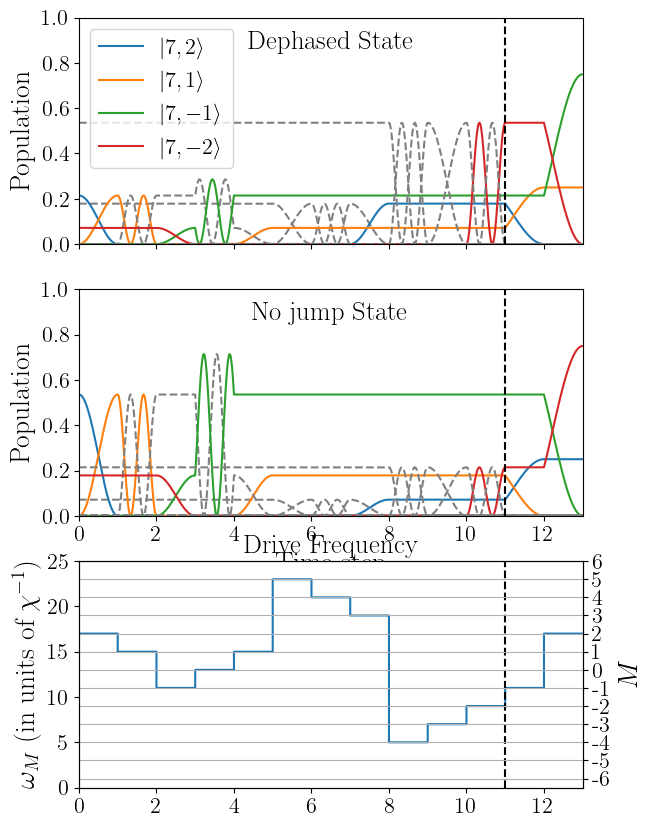

In [21]:
# creating grid for subplots
fig = plt.figure(figsize=(6.5,10))

spec = gridspec.GridSpec(ncols=1, nrows=3,
                         height_ratios=[0.33, 0.33,0.33])

ax0 = fig.add_subplot(spec[0])
ax01= fig.add_subplot(spec[1])
for i in range(len(JM)):
    if JM[i][0]==7 and (JM[i][1]== 2 or JM[i][1]== 1 or JM[i][1] == -1 or JM[i][1] == -2):# or JM[i][1] == -4):
        ax0.plot(tdata,pMd[:,i],label=r'$|{},{} \rangle$'.format(JM[i][0],JM[i][1]))
        ax01.plot(tdata,pMn[:,i],label=r'$|{},{} \rangle$'.format(JM[i][0],JM[i][1]))
    else:
        ax0.plot(tdata,pMd[:,i],color='gray',linestyle='dashed',label=None)
        ax01.plot(tdata,pMn[:,i],color='gray',linestyle='dashed',label=None)

ax0.plot(11*np.ones(10),np.linspace(0,1,10),linestyle='dashed',color='black')
ax0.set_ylim((0,1))

ax01.plot(11*np.ones(10),np.linspace(0,1,10),linestyle='dashed',color='black')
ax01.set_ylim((0,1))

ax1 = fig.add_subplot(spec[2])
ax1.plot(tdata,ww)

ax1.plot(11*np.ones(10),np.linspace(0,25,10),linestyle='dashed',color='black')
ax1.set_ylim((0,25))

ax01.set_xticklabels([])
ax01.sharex(ax0)

ax0.set_title('Dephased State', y = 0.95, pad = -14)
ax01.set_title('No jump State', y = 0.95, pad = -14)
ax1.set_title('Drive Frequency')

ax01.set_xlabel(r'Time step',fontsize=20,labelpad=5)
ax0.set_ylabel('Population',fontsize=20,labelpad=5)
ax01.set_ylabel('Population',fontsize=20,labelpad=5)
ax1.set_ylabel(r'$\omega_M$ (in units of $\chi^{-1}$)',fontsize=20,labelpad=5)
ax0.legend(loc='upper left')#, bbox_to_anchor=(1.01, 0.65))
plt.setp(ax0.get_xticklabels(), visible=False)

ax2 = ax1.twinx()
Mi = M1+1
new_tick_locations = [abs(args['chi']*(2*(M)-1)+args['omega0']) for M in np.linspace(Mi,-Mi,int(2*Mi+1))]

def tick_function():
    V = np.linspace(Mi,-Mi,int(2*Mi+1))
    return ["%.0f" % z for z in V]

ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(new_tick_locations)
ax2.set_yticklabels(tick_function())
ax2.grid()
ax2.set_ylabel(r'$M$',fontsize=20,labelpad=5)#,labelpad=6,fontsize=18)
# ax0.text(-0.15, 10., "(a)", va='center',fontsize=fontsize-1)
# ax1.text(-0.15, 5., "(b)", va='center',fontsize=fontsize-1)
ax01.set_xlim((0,13))
plt.xlim((0,13))
plt.savefig("DistinguishingStates.pdf",bbox_inches='tight',dpi=600)
plt.show()

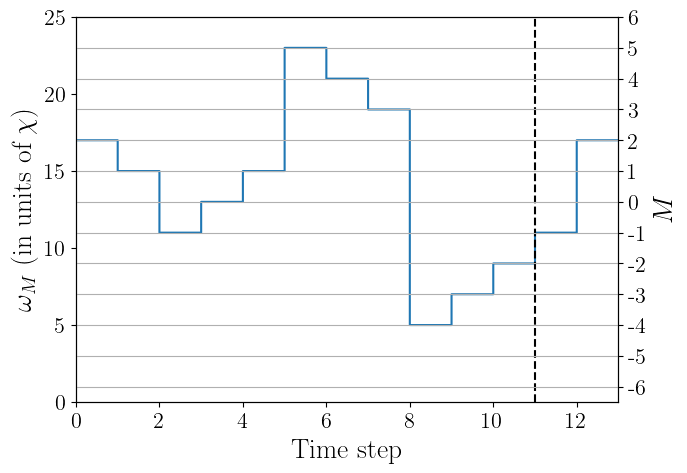

In [25]:
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)

ax1.plot(tdata,ww)
ax1.plot(11*np.ones(10),np.linspace(0,25,10),linestyle='dashed',color='black')
ax1.set_ylim((0,25))

ax1.set_ylabel(r'$\omega_M$ (in units of $\chi$)',fontsize=20,labelpad=5)

ax2 = ax1.twinx()
Mi = M1+1
new_tick_locations = [abs(args['chi']*(2*(M)-1)+args['omega0']) for M in np.linspace(Mi,-Mi,int(2*Mi+1))]

def tick_function():
    V = np.linspace(Mi,-Mi,int(2*Mi+1))
    return ["%.0f" % z for z in V]

ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(new_tick_locations)
ax2.set_yticklabels(tick_function())
ax2.grid()
ax2.set_ylabel(r'$M$',fontsize=20,labelpad=5)

ax1.set_xlabel(r'Time step',fontsize=20,labelpad=5)

plt.xlim((0,13))
plt.savefig("DriveTones.pdf",bbox_inches='tight',dpi=600)

In [ ]:
np.round(pMe[:2*7+1],4)

array([0.    , 0.    , 0.1786, 0.    , 0.    , 0.2143, 0.    , 0.    ,
       0.    , 0.0714, 0.    , 0.    , 0.5357, 0.    , 0.    ])